In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('halongquality.csv', parse_dates=['date'])
data.set_index('date', inplace=True)

In [4]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

/var/folders/4x/0fvm5hbs3kdbfhjfr87dk1_h0000gn/T/ipykernel_12569/3168631458.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0158 - val_loss: 0.0225
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0153 - val_loss: 0.0228
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0141 - val_loss: 0.0222
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0150 - val_loss: 0.0220
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.0148 - val_loss: 0.0223
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.0137 - val_loss: 0.0219
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0120 - val_loss: 0.0227
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.0126 - val_loss: 0.0246
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0129 - val_loss: 0.0225
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0112 - val_loss: 0.0228
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step -

In [12]:
# Predict the next 30 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(30):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 30 days PM2.5 predictions:", predictions.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

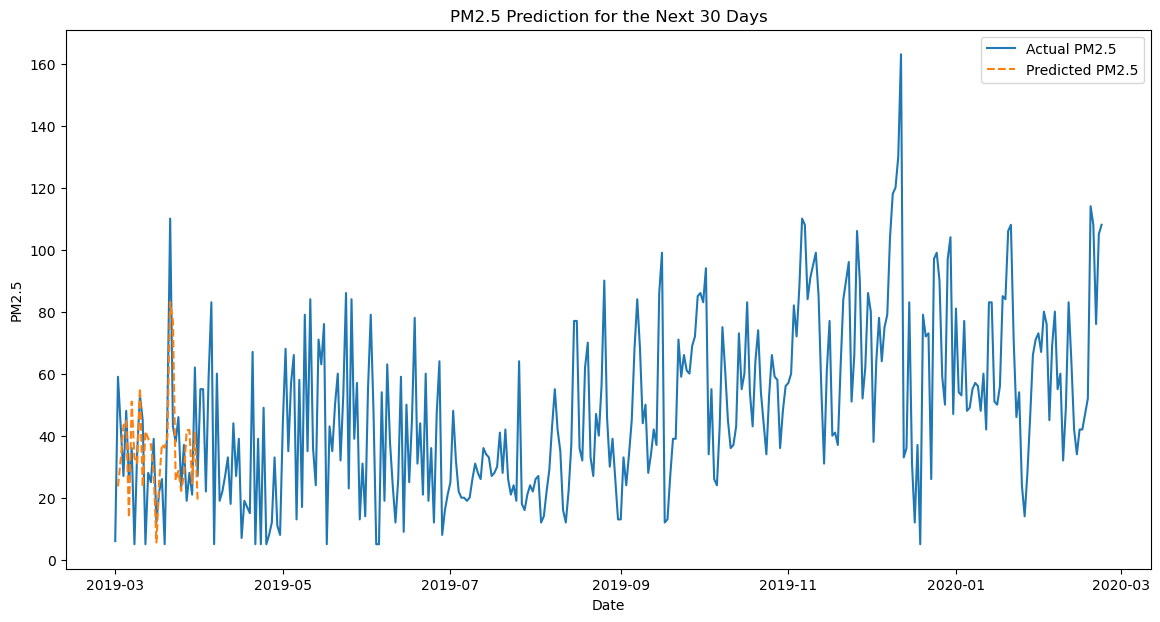

In [14]:
dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(X_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual PM2.5')
plt.plot(dates, predictions, label='Predicted PM2.5', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 Prediction for the Next 30 Days')
plt.legend()
plt.show()